In [25]:
import pandas as pd
import numpy as np
import pickle
from pathlib import Path
from sklearn_pandas import DataFrameMapper
from sklearn import preprocessing
from sklearn.metrics import normalized_mutual_info_score
import itertools
import getpass
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.pipeline import Pipeline
from collections import namedtuple
from scipy import stats
# Display more rows and get rid of the margins
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('max_colwidth',500)
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Display mulitiple values from each cell
# https://stackoverflow.com/a/42476224
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from itertools import cycle

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

# Define paths and functions

In [2]:
# Define the directories that we're going to read data from
data_dir = Path('data')
swarm_dir = Path('swarm_dir')

In [3]:
def bal_samp(df, strata, balance, order, keys, n_splits=5, n_draws=100):
    """Balanced sampling across strata

    Parameters
    ----------
    df: pandas.DataFrame
        Dataframe from which you want to sample
    strata: str or list of str
        Name(s) of the column or columns that define the groups
        from which you want a balanced sample
    balance: str or list of str
        Name(s) of the columns or columns containing the factors
        you want to evenly sample across strata
    order: str or list of str
        Name(s) of the column whose distribution you want to preserve
    keys: list of str
        Name(s) of the column(s) that you will use to match
        the output back to your original column
    n_splits: int
        Number of cross validation folds you want to create per draw
    n_draws: int
        Number of balanced samples of your dataset you want to create

    Returns
    -------
    draws_df: pandas.DataFrame
        Dataframe with number of rows about equal to number of rows in df
        and number of columns equal to n_draws + len(keys) + len(strata) + len(balance) + len(order).
        Contains the crossfold labels for balanced sampling across the strata you've defined.
    """
    # create dict of minimum count in each strata of each combination of balance factor
    bal_dict = (df.groupby(strata + balance)[[keys[0]]]
                  .nunique()
                  .groupby(balance)
                  .min()
                  .to_dict('index'))
    bal_dict = {k: v[keys[0]] for k, v in bal_dict.items()}

    # Appologies for the disgusting nested loops
    # For each draw, at each strata level, for each unique combin
    draws_df = []
    # For each draw
    for nn in range(n_draws):
        strat_df = []
        # From each strata group
        for x, gbdf in df.groupby(strata):
            cvs_df = []
            # from each unique combination of balance values
            for bal_vals, num in bal_dict.items():
                # create an index selecting the rows at those balance values
                ind = np.ones((len(gbdf))).astype(bool)
                for bcol, bv in zip(balance, bal_vals):
                    ind = np.logical_and(ind, gbdf[bcol] == bv)
                # draw a random sample of the group members
                # that meet the balance criteria
                # and sort them by the order values
                bal_df = gbdf[ind].sample(
                    n=num).sort_values(order).loc[:, keys]
                # create a list of the cross validation values long enough to match
                cv_inds = list(np.arange(n_splits))*((len(bal_df)//n_splits)+1)
                bal_df['draw_%d' % nn] = cv_inds[:len(bal_df)]
                # and append them to a list
                cvs_df.append(bal_df)
            # combine these lists to get all the rows for that strata
            # and append them to create a list of selected rows from all the strata
            strat_df.append(pd.concat(cvs_df).loc[:, ['draw_%d' % nn]])
        # pull these all together to create the draws dataframe
        draws_df.append(pd.concat(strat_df))
    draws_df = pd.concat(draws_df, axis=1)
    # Merge back in the indicator variables
    draws_df = (df.loc[:,
                       keys
                       + strata
                       + balance
                       + order]
                .merge(draws_df,
                       right_index=True,
                       left_index=True,
                       how='left')
                )
    # make sure the shape is still ok
    assert draws_df.shape[0] == df.shape[0]
    assert draws_df.shape[1] == (n_draws
                                 + len(keys)
                                 + len(strata)
                                 + len(balance)
                                 + len(order))
    return draws_df


def gen_binned_perms(df, bin_levels, n_perms=1000):
    df = df.copy(deep=True)
    permed_inds = []
    permed_inds.append(df.index.values)
    if not 'ind' in df.columns:
        df['ind'] = df.index.values
    else:
        raise Exception
    for pn in range(n_perms):
        permed_inds.append(df.groupby(bin_levels).ind.transform(
            np.random.permutation).values)
    return permed_inds


def get_cols(raw_df):
    base_meta_cols = ['contrast', 'fmri_beta_gparc_numtrs', 'fmri_beta_gparc_tr', 'lmt_run',
                      'mid_beta_seg_dof', 'task', 'collection_id', 'dataset_id', 'subjectkey',
                      'src_subject_id', 'interview_date', 'interview_age',
                      'gender', 'event_name', 'visit', 'rsfm_tr', 'eventname',
                      'rsfm_nreps', 'rsfm_numtrs', 'pipeline_version',  'scanner_manufacturer_pd',
                      'scanner_type_pd', 'mri_info_deviceserialnumber', 'magnetic_field_strength',
                      'procdate', 'collection_title', 'promoted_subjectkey', 'study_cohort_name',
                      'ehi_ss_score', '_merge', 'qc_ok', 'age_3mos', 'abcd_betnet02_id', 'fsqc_qc',
                      'rsfmri_cor_network.gordon_visitid',
                      'mrirscor02_id',  'site_id_l', 'mri_info_manufacturer',
                      'mri_info_manufacturersmn', 'mri_info_deviceserialnumber',
                      'mri_info_magneticfieldstrength', 'mri_info_softwareversion',
                      'unique_scanner', 'tbl_id', 'tbl_visitid', 
                     'modality', 'metric', 'source_file', 'tbl_id_y', 'source_file_y', 
                     'run', 'mri_info_visitid', 'dmri_dti_postqc_qc',
       'iqc_t2_ok_ser', 'iqc_mid_ok_ser', 'iqc_sst_ok_ser',
       'iqc_nback_ok_ser', 'tfmri_mid_beh_perform.flag',
       'tfmri_nback_beh_perform.flag', 'tfmri_sst_beh_perform.flag',
       'tfmri_mid_all_beta_dof', 'tfmri_mid_all_sem_dof',
       'tfmri_sst_all_beta_dof', 'tfmri_sst_all_sem_dof',
       'tfmri_nback_all_beta_dof', 'tfmri_nback_all_sem_dof',
       'mrif_score', 'mrif_hydrocephalus', 'mrif_herniation',
       'mr_findings_ok', 'tbl_numtrs', 'tbl_dof', 'tbl_nvols', 'tbl_tr', 'tbl_subthresh.nvols',
                     'rsfmri_cor_network.gordon_tr', 'rsfmri_cor_network.gordon_numtrs',
       'rsfmri_cor_network.gordon_nvols',
       'rsfmri_cor_network.gordon_subthresh.nvols',
       'rsfmri_cor_network.gordon_subthresh.contig.nvols',
       'rsfmri_cor_network.gordon_ntpoints', 'dataset_id_y', 'tbl_mean.motion', 'tbl_mean.trans', 'tbl_mean.rot',
       'tbl_max.motion', 'tbl_max.trans', 'tbl_max.rot']
    meta_cols = raw_df.columns[raw_df.columns.isin(base_meta_cols)].values
    metric_cols = raw_df.columns[~raw_df.columns.isin(base_meta_cols)].values
    return metric_cols, meta_cols

In [4]:
def big_sites(size_limit, df, metric_cols):
    notnull_mask = np.logical_and(~(df.loc[:, metric_cols].isnull().sum(1).astype(bool)),
                                  np.isfinite(df.loc[:, metric_cols]).sum(1).astype(bool))
    notnull_mask = np.logical_and(
        notnull_mask, df.unique_scanner.notnull())
    notnull_mask = np.logical_and(notnull_mask, df.qc_ok == 1)
    # for right now, just focus on sites with more than size_limit scans
    scans_per_sn = df.loc[notnull_mask, :].groupby(['unique_scanner'])[
        ['collection_id']].count().sort_values('collection_id', ascending=False)
    big_sns = df.loc[df.unique_scanner.isin(scans_per_sn.query('collection_id > @size_limit').index)
                     & notnull_mask, :]
    scans_per_bigsn = big_sns.groupby('unique_scanner')[
        ['collection_id']].count().sort_values('collection_id', ascending=False)

    print(f"Number of sites with more than {size_limit} scans:", len(
        big_sns.unique_scanner.unique()))
    print(f"Number of scans collected at sites with more than {size_limit} scans:", len(
        big_sns))
    print(f"Number of subjects collected at sites with more than {size_limit} scans:",
        big_sns.subjectkey.nunique())
    scans_per_bigsn.query('collection_id > @size_limit')
    return big_sns


def drop_bad(df, metric_cols, val_range=None, std_range=None, pct_range=None, verbose=False):
    if verbose:
        df = df.copy()
        df['cr'] = df.contrast + df.run
        full_data_subs = len(pd.unique((df.groupby('subjectkey')[['cr']].nunique() == df.groupby('subjectkey')[['cr']].nunique().max()).query('cr').index.values))

    notnull_mask = np.logical_and(~(df.loc[:, metric_cols].isnull().sum(1).astype(bool)),
                                  np.isfinite(df.loc[:, metric_cols]).sum(1).astype(bool))
    dropped_sum = (~notnull_mask).sum()
    if verbose:        
        dropped_subs = full_data_subs - len(pd.unique((df.loc[notnull_mask, :].groupby('subjectkey')[['cr']].nunique() == df.loc[notnull_mask, :].groupby('subjectkey')[['cr']].nunique().max()).query('cr').index.values))
        print(f"{dropped_sum} contrasts dropped for null data in one of the metrics")
        print(f"{dropped_subs} subjects dropped for null data in one metric on one contrast")
        full_data_subs = len(pd.unique((df.loc[notnull_mask, :].groupby('subjectkey')[['cr']].nunique() == df.loc[notnull_mask, :].groupby('subjectkey')[['cr']].nunique().max()).query('cr').index.values))
    assert notnull_mask.sum() > 0
        
    notnull_mask = np.logical_and(
        notnull_mask, df.unique_scanner.notnull())
    if verbose:
        dropped_subs = full_data_subs - len(pd.unique((df.loc[notnull_mask, :].groupby('subjectkey')[['cr']].nunique() == df.loc[notnull_mask, :].groupby('subjectkey')[['cr']].nunique().max()).query('cr').index.values))
        print(f"{(~notnull_mask).sum() - dropped_sum} contrasts dropped for not having a scanner id")
        print(f"{dropped_subs} subjects dropped for not having a scanner id")
        full_data_subs = len(pd.unique((df.loc[notnull_mask, :].groupby('subjectkey')[['cr']].nunique() == df.loc[notnull_mask, :].groupby('subjectkey')[['cr']].nunique().max()).query('cr').index.values))
    dropped_sum = (~notnull_mask).sum()
    assert notnull_mask.sum() > 0
        
    notnull_mask = np.logical_and(notnull_mask, df.qc_ok == 1)
    if verbose:
        dropped_subs = full_data_subs - len(pd.unique((df.loc[notnull_mask, :].groupby('subjectkey')[['cr']].nunique() == df.loc[notnull_mask, :].groupby('subjectkey')[['cr']].nunique().max()).query('cr').index.values))
        print(f"{(~notnull_mask).sum() - dropped_sum} contrasts dropped for failing QC")
        print(f"{dropped_subs} subjects dropped because one run failed QC")
        full_data_subs = len(pd.unique((df.loc[notnull_mask, :].groupby('subjectkey')[['cr']].nunique() == df.loc[notnull_mask, :].groupby('subjectkey')[['cr']].nunique().max()).query('cr').index.values))
    dropped_sum = (~notnull_mask).sum()
    assert notnull_mask.sum() > 0

    if val_range is not None:
        notnull_mask = np.logical_and(notnull_mask, (np.abs(
            df.loc[:, metric_cols]) < val_range).product(1).astype(bool))
        if verbose:
            dropped_subs = full_data_subs - len(pd.unique((df.loc[notnull_mask, :].groupby('subjectkey')[['cr']].nunique() == df.loc[notnull_mask, :].groupby('subjectkey')[['cr']].nunique().max()).query('cr').index.values))
            print(f"{(~notnull_mask).sum() - dropped_sum} contrasts dropped for exceeding value range")
            print(f"{dropped_subs} subjects dropped because one contrast had a value exceeding value range")
            full_data_subs = len(pd.unique((df.loc[notnull_mask, :].groupby('subjectkey')[['cr']].nunique() == df.loc[notnull_mask, :].groupby('subjectkey')[['cr']].nunique().max()).query('cr').index.values))
        dropped_sum = (~notnull_mask).sum()
        assert notnull_mask.sum() > 0

    if std_range is not None:
        notnull_mask = np.logical_and(notnull_mask, (np.abs(
            (df.loc[:, metric_cols] - df.loc[:, metric_cols].mean())/ df.loc[:, metric_cols].std()) < std_range).product(1).astype(bool))
        if verbose:
            dropped_subs = full_data_subs - len(pd.unique((df.loc[notnull_mask, :].groupby('subjectkey')[['cr']].nunique() == df.loc[notnull_mask, :].groupby('subjectkey')[['cr']].nunique().max()).query('cr').index.values))
            print(f"{(~notnull_mask).sum() - dropped_sum} contrasts dropped for exceeding variance range")
            print(f"{dropped_subs} subjects dropped because one contrast had a value exceeding variance range")
            full_data_subs = len(pd.unique((df.loc[notnull_mask, :].groupby('subjectkey')[['cr']].nunique() == df.loc[notnull_mask, :].groupby('subjectkey')[['cr']].nunique().max()).query('cr').index.values))
        dropped_sum = (~notnull_mask).sum()
        assert notnull_mask.sum() > 0

    if pct_range is not None:
        top_pct = (100-pct_range)/100
        bottom_pct = pct_range/100
        notnull_mask = np.logical_and(notnull_mask, 
            (df.loc[:, metric_cols] <= df.loc[:, metric_cols].quantile([top_pct]).iloc[0, :])
                .product(1)
                .astype(bool))
        notnull_mask = np.logical_and(notnull_mask, 
            (df.loc[:, metric_cols] >= df.loc[:, metric_cols].quantile([bottom_pct]).iloc[0, :])
                .product(1)
                .astype(bool))
        if verbose:
            dropped_subs = full_data_subs - len(pd.unique((df.loc[notnull_mask, :].groupby('subjectkey')[['cr']].nunique() == df.loc[notnull_mask, :].groupby('subjectkey')[['cr']].nunique().max()).query('cr').index.values))
            print(f"{(~notnull_mask).sum() - dropped_sum} contrasts dropped for exceeding percentile range")
            print(f"{dropped_subs} subjects dropped because one contrast had a value exceeding percentile range")
            full_data_subs = len(pd.unique((df.loc[notnull_mask, :].groupby('subjectkey')[['cr']].nunique() == df.loc[notnull_mask, :].groupby('subjectkey')[['cr']].nunique().max()).query('cr').index.values))
        dropped_sum = (~notnull_mask).sum()
        assert notnull_mask.sum() > 0
    return df.loc[notnull_mask, :].copy(deep=True)



In [5]:
def get_full_subjects(longtbl, modality, metric_range=None, **kwargs):
    
    for ii, mm in enumerate(longtbl.query('modality == @modality').metric.unique()):
        metric_df = longtbl.loc[((longtbl.modality == modality) & (longtbl.metric == mm))].copy()
        unused_cols = metric_df.columns[(metric_df.notnull().sum() == 0)].values
        metric_df.drop(unused_cols, axis=1, inplace=True)

        metric_cols, meta_cols = get_cols(metric_df)
        
        if metric_range is not None:
            try:
                metric_nb = drop_bad(metric_df, metric_cols, val_range = metric_range[mm], **kwargs)
            except KeyError:
                metric_nb = drop_bad(metric_df, metric_cols, **kwargs)
        else:
            metric_nb = drop_bad(metric_df, metric_cols, **kwargs)
        if ii == 0:
            full_subj = set(metric_nb.subjectkey.unique())
        else:
            full_subj = full_subj.intersection(metric_nb.subjectkey.unique())
    
    return full_subj

In [6]:
def make_cmd_list(user, prange, modality, metrics, bundle=5, n_draws=25,
                  run=None, task=None, contrast=None,
                  out_base='/data/nielsond/abcd/nielson_abcd_2018/',
                  swarm_dir='/data/nielsond/abcd/nielson_abcd_2018/swarm_dir'):
    if (modality =='tfmri') & ((run is None) | (task is None) | (contrast is None)):
        raise ValueError('If modality is tfmri, then run, task and contrast mus be provided')
    swarm_dir = Path(swarm_dir)
    cmds = []
    job_n = 0
    rsync_in = ''#'rsync -avch /data/MLDSST/abcd/abcd_swarm_dir /lscratch/$SLURM_JOBID/; '
    cmd = rsync_in
    for pn in range(*prange):
        for metric in metrics:
            if modality != 'tfmri':
                out_path = f'{out_base}/release11/pn-{pn:04d}_{modality}_{metric}.pkz'
            else:
                out_path = f'{out_base}/release11/pn-{pn:04d}_crt_{task}_{contrast}_{run}.pkz'

            if not Path(out_path).exists():

                perm_file = swarm_dir/f'perms_{modality}.pkz'
                ymap_file = swarm_dir/'yfit.pkz'
                if modality != 'tfmri':
                    input_file = swarm_dir/f'{modality}_{metric}.pkz'
                else:
                    input_file = swarm_dir/f'crt_{task}_{contrast}_{run}_beta.pkz '


                cmd_base = ('export SINGULARITY_BINDPATH="/gs3,/gs4,/gs5,/gs6,/gs7,/gs8,/gs9,/gs10,/gs11,/spin1,/scratch,/fdb,/data";'
                            + ' singularity exec -H ~/temp_for_singularity /data/MLDSST/singularity_images/abcd_tmp-2018-04-26-a7f5b7d6a3b4.img'
                            + f" python {swarm_dir}/run_abcd_perm_new_draws.py {pn} {perm_file}"
                            + f" {ymap_file} {input_file}"
                            + f" {out_path} 30 --n_draws={n_draws}; ")
                #rsync_out = f'rsync -ach {out_path} {local_path}; chown $USER:MLDSST {local_path}; '
                cmd +=  cmd_base #+ rsync_out
                job_n +=1
                if job_n == bundle:
                    cmds.append(cmd)
                    cmd = rsync_in
                    job_n = 0
    return cmds

#cmds = '\n'.join(cmds)
#swarm_file.write_text(cmds)

# Prep Dataframes for swarm jobs


## rs-fMRI data

In [7]:
con_old = pd.read_pickle(data_dir/'con.pkz')

con = pd.read_pickle(data_dir/'con_2.0.pkz')
# drop the subjects that are in the 1.1 release
# as well as those that don't pass qc, those without a entry for gender, and ambidexterous individiuals
con = con.loc[(~con.subjectkey.isin(con_old.subjectkey.unique())) & (con.qc_ok == True ) & (con.gender.notnull()) & (con.ehi_ss_score != 2), :]

In [8]:
singletons =con.groupby(['site_id_l',
                 'mri_info_manufacturer',
                 'mri_info_manufacturersmn',
                 'mri_info_deviceserialnumber',
                 'mri_info_softwareversion',
                 'unique_scanner']).count().query('collection_id==1').reset_index().loc[:,['site_id_l',
                 'mri_info_manufacturer',
                 'mri_info_manufacturersmn',
                 'mri_info_deviceserialnumber',
                 'mri_info_softwareversion',
                 'unique_scanner']]
singletons

,site_id_l,mri_info_manufacturer,mri_info_manufacturersmn,mri_info_deviceserialnumber,mri_info_softwareversion,unique_scanner
0,site08,GE MEDICAL SYSTEMS,DISCOVERY MR750,HASH5b2fcf80,25\LX\MR Software release:DV25.0_R02_1549.b,site08__HASH5b2fcf80__25\LX\MR Software release:DV25.0_R02_1549.b
1,site18,GE MEDICAL SYSTEMS,DISCOVERY MR750,HASHa3e45734,25\LX\MR Software release:DV25.0_R02_1549.b,site18__HASHa3e45734__25\LX\MR Software release:DV25.0_R02_1549.b
2,site22,GE MEDICAL SYSTEMS,DISCOVERY MR750,HASH48f7cbc3,25\LX\MR Software release:DV25.0_R02_1549.b,site22__HASH48f7cbc3__25\LX\MR Software release:DV25.0_R02_1549.b


In [9]:
levels = ['site_id_l',
                 'mri_info_manufacturer',
                 'mri_info_manufacturersmn',
                 'mri_info_deviceserialnumber',
                 'mri_info_softwareversion',
                 'unique_scanner']
for ii in singletons.index:
    sing_ind = pd.notnull(con.collection_id)
    for var in levels:
        sing_ind = sing_ind & (con[var] == singletons.loc[ii, var])
    singletons.loc[ii, 'interview_date'] = con.loc[sing_ind, 'interview_date'].values[0]
    singletons.loc[ii, 'min_interview_date'] = con.loc[con.site_id_l == singletons.loc[ii, 'site_id_l'], 'interview_date'].min()

In [10]:
singletons.loc[:,['site_id_l',
                 'mri_info_manufacturer',
                 'mri_info_manufacturersmn',
                 'mri_info_deviceserialnumber',
                 'mri_info_softwareversion',
                 'unique_scanner', 'interview_date', 'min_interview_date']]

,site_id_l,mri_info_manufacturer,mri_info_manufacturersmn,mri_info_deviceserialnumber,mri_info_softwareversion,unique_scanner,interview_date,min_interview_date
0,site08,GE MEDICAL SYSTEMS,DISCOVERY MR750,HASH5b2fcf80,25\LX\MR Software release:DV25.0_R02_1549.b,site08__HASH5b2fcf80__25\LX\MR Software release:DV25.0_R02_1549.b,08/16/2017,01/03/2018
1,site18,GE MEDICAL SYSTEMS,DISCOVERY MR750,HASHa3e45734,25\LX\MR Software release:DV25.0_R02_1549.b,site18__HASHa3e45734__25\LX\MR Software release:DV25.0_R02_1549.b,04/15/2017,01/02/2018
2,site22,GE MEDICAL SYSTEMS,DISCOVERY MR750,HASH48f7cbc3,25\LX\MR Software release:DV25.0_R02_1549.b,site22__HASH48f7cbc3__25\LX\MR Software release:DV25.0_R02_1549.b,03/20/2017,03/20/2017


In [11]:
con.groupby(['site_id_l', 'mri_info_manufacturer', 'mri_info_manufacturersmn', 'mri_info_softwareversion', 'unique_scanner'])[['subjectkey']].nunique()

subjectkey
site_id_l mri_info_manufacturer   mri_info_manufacturersmn mri_info_softwareversion                    unique_scanner                                                               
site01    Philips Medical Systems Achieva dStream          5.3.0\5.3.0.0                               site01__HASH6b4422a7__5.3.0\5.3.0.0                                        32
                                                           5.3.1\5.3.1.0                               site01__HASH6b4422a7__5.3.1\5.3.1.0                                       151
site02    SIEMENS                 Prisma_fit               syngo MR E11                                site02__HASH1314a204__syngo MR E11                                        248
site03    SIEMENS                 Prisma                   syngo MR E11                                site03__HASH5b0cf1bb__syngo MR E11                                        275
site04    GE MEDICAL SYSTEMS      DISCOVERY MR750          25\LX\MR Software release:DV25.0_R02_1549.b site04__HASH4b0b8b05__25\LX\MR Software release:DV25.0_R02_1549.b         167
                                                                                                       site04__HASHfeb7e81a__25\LX\MR Software release:DV25.0_R02_1549.b         103
                                                           27\LX\MR Software release:DV26.0_R02_1810.b site04__HASH4b0b8b05__27\LX\MR Software release:DV26.0_R02_1810.b           2
site05    SIEMENS                 Prisma_fit               syngo MR E11                                site05__HASH311170b9__syngo MR E11                                        176
site06    SIEMENS                 Prisma_fit               syngo MR E11                                site06__HASH96a0c182__syngo MR E11                                        265
site07    SIEMENS                 Prisma_fit               syngo MR E11                                site07__HASH65b39280__syngo MR E11                                        236
site08    GE MEDICAL SYSTEMS      DISCOVERY MR750          25\LX\MR Software release:DV25.0_R02_1549.b site08__HASH5b2fcf80__25\LX\MR Software release:DV25.0_R02_1549.b           1
                                                           27\LX\MR Software release:DV26.0_R01_1725.a site08__HASH5b2fcf80__27\LX\MR Software release:DV26.0_R01_1725.a         109
site09    SIEMENS                 Prisma_fit               syngo MR E11                                site09__HASH4d1ed7b1__syngo MR E11                                        196
site10    GE MEDICAL SYSTEMS      DISCOVERY MR750          25\LX\MR Software release:DV25.0_R02_1549.b site10__HASHd7cb4c6d__25\LX\MR Software release:DV25.0_R02_1549.b         161
                                                           27\LX\MR Software release:DV26.0_R01_1725.a site10__HASHd7cb4c6d__27\LX\MR Software release:DV26.0_R01_1725.a          40
                                                                                                       site10__HASHe3ce02d3__27\LX\MR Software release:DV26.0_R01_1725.a          53
site11    SIEMENS                 Prisma                   syngo MR E11                                site11__HASH03db707f__syngo MR E11                                        224
site12    SIEMENS                 Prisma_fit               syngo MR E11                                site12__HASH31ce566d__syngo MR E11                                         12
                                                                                                       site12__HASHe4f6957a__syngo MR E11                                        312
site13    GE MEDICAL SYSTEMS      DISCOVERY MR750          25\LX\MR Software release:DV25.0_R02_1549.b site13__HASHc3bf3d9c__25\LX\MR Software release:DV25.0_R02_1549.b         118
                                                           27\LX\MR Software release:DV25.1_R01_1617.b site13__HASH69f406fa__27\LX\MR Software release:DV25.1_R01_1617.b          75
       

In [12]:
# Stie and scanner are almost compltely compounded, 
# so we'll just drop the smaller of the scanner that comes from a site with more scans
con = con.loc[con.unique_scanner != 'site04__HASHfeb7e81a__25\LX\MR Software release:DV25.0_R02_1549.b', :].copy(deep=True)

In [33]:
98 * 26

2548

In [13]:
# Process connectivity data
# If processed connectivity data doesn't exist, create it
big_con_file = swarm_dir/'big_con.pkz'
if not big_con_file.exists():
    print("No processed connectivity data file found. Generating a new one.")
    #con = pd.read_pickle(data_dir/'con.pkz')
    #con.loc[con.mri_info_manufacturersmn == 'DISCOVERY MR750', 'mri_info_manufacturersmn'] = 'AAAA DISCOVERY MR750'
    con_metric_cols, con_meta_cols = get_cols(con)
    big_con = big_sites(100, con, con_metric_cols)

    big_con.to_pickle(big_con_file)
else:
    big_con = pd.read_pickle(big_con_file)

# Look at counts in connectivity data
big_con.groupby(['site_id_l',
                 'mri_info_manufacturer',
                 'mri_info_manufacturersmn',
                 'mri_info_deviceserialnumber',
                 'mri_info_softwareversion',
                 'unique_scanner']).count()

No processed connectivity data file found. Generating a new one.
Number of sites with more than 100 scans: 20
Number of scans collected at sites with more than 100 scans: 4258
Number of subjects collected at sites with more than 100 scans: 4258


,,,,,,collection_id,abcd_betnet02_id,dataset_id,subjectkey,src_subject_id,interview_date,interview_age,gender,eventname,rsfmri_cor_network.gordon_visitid,rsfmri_cor_network.gordon_tr,rsfmri_cor_network.gordon_numtrs,rsfmri_cor_network.gordon_nvols,rsfmri_cor_network.gordon_subthresh.nvols,rsfmri_cor_network.gordon_subthresh.contig.nvols,rsfmri_cor_network.gordon_ntpoints,rsfmri_cor_network.gordon_mean.motion,rsfmri_cor_network.gordon_max.motion,rsfmri_cor_network.gordon_mean.trans,rsfmri_cor_network.gordon_max.trans,rsfmri_cor_network.gordon_mean.rot,rsfmri_cor_network.gordon_max.rot,rsfmri_cor_network.gordon_auditory_network.gordon_auditory,rsfmri_cor_network.gordon_auditory_network.gordon_cingulooperc,rsfmri_cor_network.gordon_auditory_network.gordon_cinguloparietal,rsfmri_cor_network.gordon_auditory_network.gordon_default,rsfmri_cor_network.gordon_auditory_network.gordon_dorsalattn,rsfmri_cor_network.gordon_auditory_network.gordon_frontoparietal,rsfmri_cor_network.gordon_auditory_network.gordon_none,rsfmri_cor_network.gordon_auditory_network.gordon_retrosplenialtemporal,rsfmri_cor_network.gordon_auditory_network.gordon_smhand,rsfmri_cor_network.gordon_auditory_network.gordon_smmouth,rsfmri_cor_network.gordon_auditory_network.gordon_salience,rsfmri_cor_network.gordon_auditory_network.gordon_ventralattn,rsfmri_cor_network.gordon_auditory_network.gordon_visual,rsfmri_cor_network.gordon_cingulooperc_network.gordon_auditory,rsfmri_cor_network.gordon_cingulooperc_network.gordon_cingulooperc,rsfmri_cor_network.gordon_cingulooperc_network.gordon_cinguloparietal,rsfmri_cor_network.gordon_cingulooperc_network.gordon_default,rsfmri_cor_network.gordon_cingulooperc_network.gordon_dorsalattn,rsfmri_cor_network.gordon_cingulooperc_network.gordon_frontoparietal,rsfmri_cor_network.gordon_cingulooperc_network.gordon_none,rsfmri_cor_network.gordon_cingulooperc_network.gordon_retrosplenialtemporal,rsfmri_cor_network.gordon_cingulooperc_network.gordon_smhand,rsfmri_cor_network.gordon_cingulooperc_network.gordon_smmouth,rsfmri_cor_network.gordon_cingulooperc_network.gordon_salience,rsfmri_cor_network.gordon_cingulooperc_network.gordon_ventralattn,rsfmri_cor_network.gordon_cingulooperc_network.gordon_visual,rsfmri_cor_network.gordon_cinguloparietal_network.gordon_auditory,rsfmri_cor_network.gordon_cinguloparietal_network.gordon_cingulooperc,rsfmri_cor_network.gordon_cinguloparietal_network.gordon_cinguloparietal,rsfmri_cor_network.gordon_cinguloparietal_network.gordon_default,rsfmri_cor_network.gordon_cinguloparietal_network.gordon_dorsalattn,rsfmri_cor_network.gordon_cinguloparietal_network.gordon_frontoparietal,rsfmri_cor_network.gordon_cinguloparietal_network.gordon_none,rsfmri_cor_network.gordon_cinguloparietal_network.gordon_retrosplenialtemporal,rsfmri_cor_network.gordon_cinguloparietal_network.gordon_smhand,rsfmri_cor_network.gordon_cinguloparietal_network.gordon_smmouth,rsfmri_cor_network.gordon_cinguloparietal_network.gordon_salience,rsfmri_cor_network.gordon_cinguloparietal_network.gordon_ventralattn,rsfmri_cor_network.gordon_cinguloparietal_network.gordon_visual,rsfmri_cor_network.gordon_default_network.gordon_auditory,rsfmri_cor_network.gordon_default_network.gordon_cingulooperc,rsfmri_cor_network.gordon_default_network.gordon_cinguloparietal,rsfmri_cor_network.gordon_default_network.gordon_default,rsfmri_cor_network.gordon_default_network.gordon_dorsalattn,rsfmri_cor_network.gordon_default_network.gordon_frontoparietal,rsfmri_cor_network.gordon_default_network.gordon_none,rsfmri_cor_network.gordon_default_network.gordon_retrosplenialtemporal,rsfmri_cor_network.gordon_default_network.gordon_smhand,rsfmri_cor_network.gordon_default_network.gordon_smmouth,rsfmri_cor_network.gordon_default_network.gordon_salience,rsfmri_cor_network.gordon_default_network.gordon_ventralattn,rsfmri_cor_network.gordon_default_network.gordon_visual,rsfmri_cor_network.gordon_dorsalattn_network.gordon_auditory,rsfmri_cor_network.gordon_dorsalattn_network.gordo

In [32]:
con.groupby(['mri_info_manufacturer', 'mri_info_manufacturersmn']).site_id_l.nunique()

mri_info_manufacturer    mri_info_manufacturersmn
GE MEDICAL SYSTEMS       DISCOVERY MR750              6
Philips Medical Systems  Achieva dStream              2
                         Ingenia                      1
SIEMENS                  Prisma                       5
                         Prisma_fit                  10
Name: site_id_l, dtype: int64

In [14]:
# Load permutations or generate them
perm_file = swarm_dir/'perms_con.pkz'
if not perm_file.exists():
    print("No connectivity permutation file found. Generating a new one.")
    # within bucket shuffle
    big_con['age_3mos'] = (big_con['interview_age'] // 3) * 3
    bin_levels = ['gender', 'ehi_ss_score', 'age_3mos']
    con_perms = gen_binned_perms(big_con, bin_levels, n_perms=2000)
    with open(perm_file.as_posix(), 'wb') as h:
        pickle.dump(con_perms, h)
else:
    with open(perm_file.as_posix(), 'rb') as h:
        con_perms = pickle.load(h)

# If ymapper doesn't exist, create it
# We're doing this outside the swarm to ensure that every worker has the same
# encoding of the categories
ymap_file = swarm_dir/'yfit_con.pkz'
if not ymap_file.exists():
    print("No connectivity ymapper file found. Generating a new one.")

    ymapper = DataFrameMapper([("unique_scanner",preprocessing.LabelEncoder())])
    yfit = ymapper.fit(big_con)
    with open(swarm_dir/'yfit_con.pkz', 'wb') as h:
        pickle.dump(yfit, h)

No connectivity permutation file found. Generating a new one.


/data/nielsond/python/envs/abcd_mine/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


No connectivity ymapper file found. Generating a new one.


We'll be generating these folds anew for each permutation to make sure that all the CV folds in the perms have the same counts in them, but I'm running htis code here so that I can pull out information about the draws.

In [15]:
# Create cv folds for gender handedness balance
strata = ['unique_scanner']
balance = ['gender', 'ehi_ss_score']
order = ['interview_age']
keys = ['subjectkey', 'interview_date']
n_draws = 25
n_splits = 3
ab_n_splits = 2
draws_df = bal_samp(big_con, strata, balance, order, keys, n_splits=n_splits, n_draws=n_draws)

# Prep data for gender handedness age_balance
strata = ['unique_scanner']
balance = ['gender', 'ehi_ss_score','age_3mos']
order = ['interview_age']
keys = ['subjectkey', 'interview_date']
df_ab = big_con.copy(deep=True)
df_ab['age_3mos'] = (df_ab['interview_age'] // 3) * 3

count_by_level = df_ab.groupby(strata+balance)[['subjectkey']].nunique().reset_index()
levels_counts = (count_by_level[count_by_level.subjectkey >= ab_n_splits]
                 .groupby(balance)[strata]
                 .nunique()
                 .reset_index()
                 .rename(columns={'unique_scanner':'sufficient_sites'}))

# Look at the categories of subjects that have enough data per site
print("These are the categories of subjects with enough data per site.")
print("Enough defined as at least %d subjects in that category per site"%ab_n_splits)
levels_counts.loc[levels_counts.sufficient_sites == levels_counts.sufficient_sites.max()]

df_ab = df_ab.reset_index().merge(levels_counts, how='left', on=['gender','ehi_ss_score', 'age_3mos']).set_index('index')
df_ab = df_ab.loc[df_ab.sufficient_sites == df_ab.sufficient_sites.max(),:]
ab_draws_df = bal_samp(df_ab, strata, balance, order, keys, n_splits=ab_n_splits, n_draws=n_draws)

These are the categories of subjects with enough data per site.
Enough defined as at least 2 subjects in that category per site


,gender,ehi_ss_score,age_3mos,sufficient_sites
1,F,1.0,108,20
2,F,1.0,111,20
3,F,1.0,114,20
4,F,1.0,117,20
5,F,1.0,120,20
6,F,1.0,123,20
7,F,1.0,126,20
8,F,1.0,129,20
20,M,1.0,108,20
21,M,1.0,111,20


In [38]:
big_con.groupby(['gender', 'ehi_ss_score']).subjectkey.nunique()

gender  ehi_ss_score
F       1.0             1881
        3.0              301
M       1.0             1805
        3.0              271
Name: subjectkey, dtype: int64

In [16]:
def calc_draw_mis(ab_draws_df):
    draw_labels = ['draw_0', 'draw_1',
           'draw_2', 'draw_3', 'draw_4', 'draw_5', 'draw_6', 'draw_7', 'draw_8',
           'draw_9', 'draw_10', 'draw_11', 'draw_12', 'draw_13', 'draw_14',
           'draw_15', 'draw_16', 'draw_17', 'draw_18', 'draw_19', 'draw_20',
           'draw_21', 'draw_22', 'draw_23', 'draw_24']
    mis = []
    for ii, dli in enumerate(draw_labels):
        for jj, dlj in enumerate(draw_labels[(ii+1):]):
            mir = {}
            mir['draw_a'] = dli
            mir['draw_b'] = dlj
            mir['mi'] = normalized_mutual_info_score((ab_draws_df[dli] == 1).values, (ab_draws_df[dlj] == 1).values)
            mis.append(mir)    
    mis = pd.DataFrame(mis)
    return mis


In [17]:
mis = calc_draw_mis(ab_draws_df)
mis.mi.mean()

/data/nielsond/python/envs/abcd_mine/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


0.018630177880175354

## task-based data

In [19]:
longtbl_old = pd.read_pickle(data_dir/'long_table.pkz')
longtbl = pd.read_pickle(data_dir/'long_table_2.0.pkz')

longtbl['unique_scanner'] = longtbl.site_id_l + '__' + longtbl.mri_info_deviceserialnumber + '__' + longtbl.mri_info_softwareversion

print(longtbl.subjectkey.nunique())
longtbl = longtbl.loc[(~longtbl.subjectkey.isin(longtbl_old.subjectkey.unique())), :]
print(longtbl.subjectkey.nunique())
longtbl = longtbl.loc[(longtbl.ehi_ss_score == 1), :]
print(longtbl.subjectkey.nunique())
longtbl = longtbl.loc[longtbl.gender.notnull(), :]
print(longtbl.subjectkey.nunique())

tb_b = longtbl.loc[((longtbl.modality == 'tfmri') & (longtbl.metric == 'beta') & (longtbl.run != 'all'))].copy().reset_index(drop=True)

unused_cols = tb_b.groupby(['task','run','metric','contrast']).count().sum().index[tb_b.groupby(['task','run','metric', 'contrast']).count().sum() < 7000]

tb_b.drop(unused_cols, axis=1, inplace=True)

metric_cols, meta_cols = get_cols(tb_b)

7778
4834
3884
3882


### Ymapper

In [20]:
# If ymapper doesn't exist, create it
# We're doing this outside the swarm to ensure that every worker has the same
# encoding of the categories
ymap_file = swarm_dir/f'yfit.pkz'
if not ymap_file.exists():
    ymapper = DataFrameMapper([("unique_scanner",preprocessing.LabelEncoder())])
    yfit = ymapper.fit(longtbl[longtbl.unique_scanner.notnull()])
    with open(ymap_file, 'wb') as h:
        pickle.dump(yfit, h)
else:
    with open(ymap_file, 'rb') as h:
        yfit = pickle.load(h)

In [21]:
# with single run per subject
# For task based analysis limit to only subjects that have data across all tasks and runs
tb_b_nb = drop_bad(tb_b, metric_cols, verbose=True, pct_range=0.25)
tb_b_nb['cr'] = tb_b_nb.contrast + tb_b_nb.run
# Get the first complete run for each task for each subject
contrasts_per_run = pd.DataFrame(tb_b_nb
                                 .groupby(['subjectkey', 'task', 'run'])
                                 .collection_id.count()
                                 .reset_index()
                                 .groupby(['task', 'run'])
                                 .collection_id.max()
                                ).rename(columns={'collection_id':'max_ncontrasts'}).reset_index()
subj_cpr = pd.DataFrame(tb_b_nb.groupby(['subjectkey', 'task', 'run'])
                        .collection_id
                        .count()
                       ).rename(columns={'collection_id':'ncontrasts'}).reset_index()
subj_cpr = subj_cpr.merge(contrasts_per_run, how='left', on=['task', 'run'])
subj_cpr = subj_cpr.loc[subj_cpr.ncontrasts == subj_cpr.max_ncontrasts].sort_values(['subjectkey', 'task', 'run'])
tb_b_nb = (subj_cpr
             .groupby(['subjectkey', 'task'])[['run']].first()
             .reset_index()
             .merge(tb_b_nb, on=['subjectkey', 'task', 'run'], how='left'))
full_data_subs = pd.unique((tb_b_nb.groupby('subjectkey')[['cr']].nunique() == tb_b_nb.groupby('subjectkey')[['cr']].nunique().max()).query('cr').index.values)
tb_b_full = tb_b_nb.loc[tb_b_nb.subjectkey.isin(full_data_subs), :]



#winsorize values
# pct_range = 0.25
# top_pct = (100-pct_range)/100
# bottom_pct = pct_range/100
# tb_b_full.loc[:, metric_cols] = tb_b_full.loc[:, metric_cols].clip(tb_b_full.quantile(bottom_pct), tb_b_full.quantile(top_pct), axis=1)

print(f'nsubs = {tb_b_full.subjectkey.nunique()}')
big_crs = []
for x,df in tb_b_full.query('run != "all"').groupby(['contrast']):
    tmp = big_sites(50, df, metric_cols).sort_values('subjectkey').reset_index()
    assert len(tmp) > 0
    big_crs.append(tmp)
big_crs[-1].groupby(['mri_info_manufacturer',
                      'mri_info_manufacturersmn','unique_scanner']).count()
assert np.array([(big_crs[0].subjectkey == bc.subjectkey).all() for bc in big_crs]).all()

1233 contrasts dropped for null data in one of the metrics
118 subjects dropped for null data in one metric on one contrast
0 contrasts dropped for not having a scanner id
0 subjects dropped for not having a scanner id
26565 contrasts dropped for failing QC
1009 subjects dropped because one run failed QC
9732 contrasts dropped for exceeding percentile range
1187 subjects dropped because one contrast had a value exceeding percentile range
nsubs = 2286
Number of sites with more than 50 scans: 17
Number of scans collected at sites with more than 50 scans: 1953
Number of subjects collected at sites with more than 50 scans: 1953
Number of sites with more than 50 scans: 17
Number of scans collected at sites with more than 50 scans: 1953
Number of subjects collected at sites with more than 50 scans: 1953
Number of sites with more than 50 scans: 17
Number of scans collected at sites with more than 50 scans: 1953
Number of subjects collected at sites with more than 50 scans: 1953
Number of site

index  \
mri_info_manufacturer   mri_info_manufacturersmn unique_scanner                                                             
GE MEDICAL SYSTEMS      DISCOVERY MR750          site10__HASHd7cb4c6d__25\LX\MR Software release:DV25.0_R02_1549.b     55   
                                                 site13__HASHc3bf3d9c__25\LX\MR Software release:DV25.0_R02_1549.b     53   
                                                 site18__HASHa3e45734__27\LX\MR Software release:DV26.0_R01_1725.a     54   
Philips Medical Systems Achieva dStream          site01__HASH6b4422a7__5.3.1\5.3.1.0                                   70   
                                                 site17__HASHdb2589d4__5.3.1\5.3.1.0                                   55   
SIEMENS                 Prisma                   site03__HASH5b0cf1bb__syngo MR E11                                   147   
                                                 site11__HASH03db707f__syngo MR E11                                    90   
                                                 site14__HASH11ad4ed5__syngo MR E11                                    99   
                                                 site16__HASH3935c89e__syngo MR E11                                   346   
                                                 site20__HASHd422be27__syngo MR E11                                   130   
                        Prisma_fit               site02__HASH1314a204__syngo MR E11                                   132   
                                                 site05__HASH311170b9__syngo MR E11                                    82   
                                                 site06__HASH96a0c182__syngo MR E11                                   172   
                                                 site07__HASH65b39280__syngo MR E11                                   111   
                                                 site09__HASH4d1ed7b1__syngo MR E11                                   104   
                                                 site12__HASHe4f6957a__syngo MR E11                                   161   
                                                 site21__HASHb640a1b8__syngo MR E11                                    92   

                                                                                                                    subjectkey  \
mri_info_manufacturer   mri_info_manufacturersmn unique_scanner                                                                  
GE MEDICAL SYSTEMS      DISCOVERY MR750          site10__HASHd7cb4c6d__25\LX\MR Software release:DV25.0_R02_1549.b          55   
                                                 site13__HASHc3bf3d9c__25\LX\MR Software release:DV25.0_R02_1549.b          53   
                                                 site18__HASHa3e45734__27\LX\MR Software release:DV26.0_R01_1725.a          54   
Philips Medical Systems Achieva dStream          site01__HASH6b4422a7__5.3.1\5.3.1.0                                        70   
                                                 site17__HASHdb2589d4__5.3.1\5.3.1.0                                        55   
SIEMENS                 Prisma                   site03__HASH5b0cf1bb__syngo MR E11                                        147   
                                                 site11__HASH03db707f__syngo MR E11                                         90   
                                                 site14__HASH11ad4ed5__syngo MR E11                                         99   
                                                 site16__HASH3935c89e__syngo MR E11                                        346   
                                                 site20__HASHd422be27__syngo MR E11                                        130   
                        Prisma_fit               site02__HASH1314a204__syngo MR E11                                        132   
                                                 s

In [22]:
for crt in big_crs:
    assert (crt.index == big_crs[0].index).all()
    task = crt.task.unique()[0]
    run = crt.run.unique()[0]
    contrast = '-'.join(crt.contrast.unique()[0].split())
    crt_file = swarm_dir/f'crt_{task}_{contrast}_{run}_beta.pkz'
    if not crt_file.exists():
        crt.to_pickle(crt_file)

# Load permutations or generate them
crt_perm_file = swarm_dir/'perms_tmri.pkz'
if not crt_perm_file.exists():
    print("No task based permutation file found. Generating a new one.")
    # within bucket shuffle
    big_crs[0]['age_3mos'] = (big_crs[0]['interview_age'] // 3) * 3
    bin_levels = ['gender', 'ehi_ss_score', 'age_3mos']
    crt_perms = gen_binned_perms(big_crs[0], bin_levels, n_perms=2000)
    with open(crt_perm_file, 'wb') as h:
        pickle.dump(crt_perms, h)
else:
    with open(crt_perm_file.as_posix(), 'rb') as h:
        crt_perms = pickle.load(h)

# If ymapper doesn't exist, create it
# We're doing this outside the swarm to ensure that every worker has the same
# encoding of the categories
crt_ymap_file = swarm_dir/'yfit_crt_beta.pkz'
if not crt_ymap_file.exists():
    crt_ymapper = DataFrameMapper([("unique_scanner",preprocessing.LabelEncoder())])
    crt_yfit = crt_ymapper.fit(big_crs[0])
    with open(crt_ymap_file, 'wb') as h:
        pickle.dump(crt_yfit, h)
else:
    with open(crt_ymap_file, 'rb') as h:
        crt_yfit = pickle.load(h)

No task based permutation file found. Generating a new one.


In [23]:
# Create cv folds for gender handedness balance
strata = ['unique_scanner']
balance = ['gender', 'ehi_ss_score']
order = ['interview_age']
keys = ['subjectkey', 'interview_date']
n_draws = 25
n_splits = 3
ab_n_splits = 2
draws_df = bal_samp(big_crs[0], strata, balance, order, keys, n_splits=n_splits, n_draws=n_draws)

/data/nielsond/python/envs/abcd_mine/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


0.00837957933153685

/data/nielsond/python/envs/abcd_mine/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


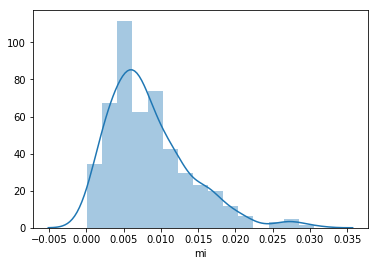

In [26]:
mis = calc_draw_mis(draws_df)
mis.mi.mean()
sns.distplot(mis.mi)

In [27]:
# Prep data for gender handedness age_balance
strata = ['unique_scanner']
balance = ['gender', 'ehi_ss_score','age_3mos']
order = ['interview_age']
keys = ['subjectkey', 'interview_date']
df_ab = big_crs[0].copy(deep=True)
df_ab['age_3mos'] = (df_ab['interview_age'] // 3) * 3

count_by_level = df_ab.groupby(strata+balance)[['subjectkey']].nunique().reset_index()
levels_counts = (count_by_level[count_by_level.subjectkey >= ab_n_splits]
                 .groupby(balance)[strata]
                 .nunique()
                 .reset_index()
                 .rename(columns={'unique_scanner':'sufficient_sites'}))

# Look at the categories of subjects that have enough data per site
print("These are the categories of subjects with enough data per site.")
print("Enough defined as at least %d subjects in that category per site"%ab_n_splits)
levels_counts.loc[levels_counts.sufficient_sites == levels_counts.sufficient_sites.max()]

df_ab = df_ab.reset_index().merge(levels_counts, how='left', on=['gender','ehi_ss_score', 'age_3mos']).set_index('index')
df_ab = df_ab.loc[df_ab.sufficient_sites == df_ab.sufficient_sites.max(),:]
ab_draws_df = bal_samp(df_ab, strata, balance, order, keys, n_splits=ab_n_splits, n_draws=n_draws)

These are the categories of subjects with enough data per site.
Enough defined as at least 2 subjects in that category per site


,gender,ehi_ss_score,age_3mos,sufficient_sites
1,F,1.0,108,17
3,F,1.0,114,17
6,F,1.0,123,17
7,F,1.0,126,17
8,F,1.0,129,17
11,M,1.0,108,17
18,M,1.0,129,17


0.04113988522701708

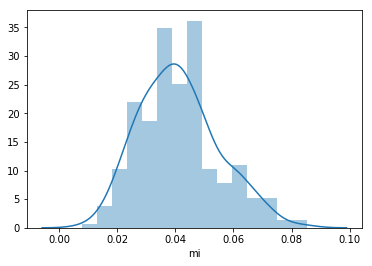

In [28]:
mis = calc_draw_mis(ab_draws_df)
mis.mi.mean()
sns.distplot(mis.mi)

In [30]:
metric_cols

array(['cort.desikan__bankssts.lh',
       'cort.desikan__caudalanteriorcingulate.lh',
       'cort.desikan__caudalmiddlefrontal.lh', 'cort.desikan__cuneus.lh',
       'cort.desikan__entorhinal.lh', 'cort.desikan__fusiform.lh',
       'cort.desikan__inferiorparietal.lh',
       'cort.desikan__inferiortemporal.lh',
       'cort.desikan__isthmuscingulate.lh',
       'cort.desikan__lateraloccipital.lh',
       'cort.desikan__lateralorbitofrontal.lh',
       'cort.desikan__lingual.lh', 'cort.desikan__medialorbitofrontal.lh',
       'cort.desikan__middletemporal.lh',
       'cort.desikan__parahippocampal.lh', 'cort.desikan__paracentral.lh',
       'cort.desikan__parsopercularis.lh',
       'cort.desikan__parsorbitalis.lh',
       'cort.desikan__parstriangularis.lh',
       'cort.desikan__pericalcarine.lh', 'cort.desikan__postcentral.lh',
       'cort.desikan__posteriorcingulate.lh',
       'cort.desikan__precentral.lh', 'cort.desikan__precuneus.lh',
       'cort.desikan__rostralanteriorcing

# Write swarm files

## rs-fMRI data

In [30]:
# TODO: Clean up paths here
from pathlib import Path
swarm_file = Path('swarm_con')
cmds = []
for pn in range(0,101):

    out_path = '/data/nielsond/abcd/nielson_abcd_2018/release11/pn-%04d_con_unadj.pkz'%(pn)
    cmd_base = ( 'export SINGULARITY_BINDPATH="/gs3,/gs4,/gs5,/gs6,/gs7,/gs8,/gs9,/gs10,/gs11,/spin1,/scratch,/fdb,/data";'
                + ' singularity exec -H ~/temp_for_singularity /data/MLDSST/singularity_images/abcd_tmp-2018-04-26-a7f5b7d6a3b4.img'
                + f" python /data/nielsond/abcd/nielson_abcd_2018/swarm_dir/run_abcd_perm_new_draws.py {pn} /data/nielsond/abcd/nielson_abcd_2018/swarm_dir/perms_con.pkz "
                + f"/data/nielsond/abcd/nielson_abcd_2018/swarm_dir/yfit_con.pkz /data/nielsond/abcd/nielson_abcd_2018/swarm_dir/big_con.pkz "
                + f"{out_path} 30 --n_draws={n_draws} --do_ab; ")
    cmds.append(cmd_base)

cmds = '\n'.join(cmds)
swarm_file.write_text(cmds)

58671

In [22]:
len(cmds.split('\n'))

1

In [31]:
# Then, outside of jupyter, run the swarm file:
!swarm -f swarm_con -g 64 -t 32 --logdir swarm_log --time 4:00:00 --partition=norm,quick --gres=lscratch:20 --module=singularity

15977083


In [26]:
print(cmds)

export SINGULARITY_BINDPATH="/gs3,/gs4,/gs5,/gs6,/gs7,/gs8,/gs9,/gs10,/gs11,/spin1,/scratch,/fdb,/data"; singularity exec -H ~/temp_for_singularity /data/MLDSST/singularity_images/abcd_tmp-2018-04-26-a7f5b7d6a3b4.img python /data/nielsond/abcd/nielson_abcd_2018/swarm_dir/run_abcd_perm_new_draws.py 0 /data/nielsond/abcd/nielson_abcd_2018/swarm_dir/perms_con.pkz /data/nielsond/abcd/nielson_abcd_2018/swarm_dir/yfit_con.pkz /data/nielsond/abcd/nielson_abcd_2018/swarm_dir/big_con.pkz /data/nielsond/abcd/nielson_abcd_2018/pn-0000_con_unadj.pkz 30 --n_draws=25 --do_ab; 


In [ ]:
. activate abcd_mine && python /data/nielsond/abcd/nielson_abcd_2018/swarm_dir/run_abcd_perm_new_draws.py 0 /data/nielsond/abcd/nielson_abcd_2018/swarm_dir/perms_con.pkz /data/nielsond/abcd/nielson_abcd_2018/swarm_dir/yfit_con.pkz /data/nielsond/abcd/nielson_abcd_2018/swarm_dir/big_con.pkz /data/nielsond/abcd/nielson_abcd_2018/pn-0000_con_unadj.pkz 2 --n_draws=25 --do_ab; 

## Task-based data

In [ ]:
crt_combinations = longtbl.query('modality == "tfmri" & metric == "beta" & run != "all"').groupby(['task','contrast','run']).size().reset_index().drop(0,axis=1).to_records(index=False)

In [ ]:
for task, contrast, run in crt_combinations:
    print(task,contrast,run)

In [ ]:
!{user_cmds['nielsond'][0]}

In [302]:
import time

In [ ]:
time.sleep()

In [308]:
for user,items in user_cmds.items():
    if user == getpass.getuser():
        for cmd in items[1:]:
            notsubmitted = True
            while notsubmitted:
                print(cmd)
                !{cmd}
                if _exit_code == 0:
                    notsubmitted=False
                else:
                    print("wait an hour and then try again")
                    time.sleep(3600)

swarm -f /data/nielsond/abcd/nielson_abcd_2018/swarm_dir/swarm_test_tfmri_0_1000_nielsond_4_11 -g 12 -t auto --logdir ${USER}_swarm_log --time 2:30:00 --partition=quick,norm --gres=lscratch:30 --module singularity --exclusive --sbatch "--constraint=core16"
15893326
swarm -f /data/nielsond/abcd/nielson_abcd_2018/swarm_dir/swarm_test_tfmri_0_2000_nielsond_4_11 -g 12 -t auto --logdir ${USER}_swarm_log --time 2:30:00 --partition=quick,norm --gres=lscratch:30 --module singularity --exclusive --sbatch "--constraint=core16"
15893327
swarm -f /data/nielsond/abcd/nielson_abcd_2018/swarm_dir/swarm_test_tfmri_0_3000_nielsond_4_11 -g 12 -t auto --logdir ${USER}_swarm_log --time 2:30:00 --partition=quick,norm --gres=lscratch:30 --module singularity --exclusive --sbatch "--constraint=core16"
sbatch.exe: error: Batch job submission failed: Job violates accounting/QOS policy (job submit limit, user's size and/or time limits)
ERROR: Something went wrong with sbatch!  I don't know the jobid!
wait an hou

KeyboardInterrupt: 

In [ ]:
users=['nielsond']
user_cmds = {u:[] for u in users}
users = cycle(users)
pstep = 100
pranges = [(0,101)]
i = 0
loop_n = 4
modality='tfmri'
for pr in pranges:
    cmds =[]
    for task, contrast, run in crt_combinations:
        cmds.extend(make_cmd_list(user, pr, modality, 'beta', bundle=2, run=run, task=task, contrast=contrast))
    user = next(users)
    jobs_per_swarm = 1000
    swarm_files = []
    for ii in range(0, len(cmds), jobs_per_swarm):
        swarm_file = Path('/data/nielsond/abcd/nielson_abcd_2018/swarm_dir/swarm_test_%s_%d_%d_%s_%d_11'%(modality, pr[0],ii,user, loop_n))
        swarm_files.append(swarm_file.as_posix())
        swarm_file.write_text('\n'.join(cmds[ii:ii+jobs_per_swarm]))
        swarm_cmd = f'swarm -f {swarm_file} -g 12 -t auto --logdir ${{USER}}_swarm_log --time 2:30:00 --partition=quick,norm --gres=lscratch:30 --module singularity --exclusive --sbatch "--constraint=core16"'
        user_cmds[user].append(swarm_cmd)
        print(len(cmds[ii:ii+jobs_per_swarm]))


In [301]:
_exit_code

0

In [300]:
items[3]

'swarm -f /data/nielsond/abcd/nielson_abcd_2018/swarm_dir/swarm_test_tfmri_0_3000_nielsond_4_11 -g 12 -t auto --logdir ${USER}_swarm_log --time 2:30:00 --partition=quick,norm --gres=lscratch:30 --module singularity --exclusive --sbatch "--constraint=core16"'

# structural mri

In [36]:
longtbl = pd.read_pickle(data_dir/'long_table.pkz')
longtbl['unique_scanner'] = longtbl.site_id_l + '__' + longtbl.mri_info_deviceserialnumber + '__' + longtbl.mri_info_softwareversion
longtbl['age_3mos'] = (longtbl['interview_age'] // 3) * 3
longtbl.drop(['subcort.aseg__wm.hypointensities.rh', 'subcort.aseg__wm.hypointensities.lh'], axis=1, inplace=True)
modality = 'smri'

In [37]:
full_subjs = get_full_subjects(longtbl, modality)

metric_cols={}
for mm in longtbl.query('modality == @modality').metric.unique():
    metric_df = longtbl.loc[((longtbl.modality == modality) & (longtbl.metric == mm))].copy()
    unused_cols = metric_df.columns[(metric_df.notnull().sum() == 0)].values
    metric_df.drop(unused_cols, axis=1, inplace=True)

    metric_cols, meta_cols = get_cols(metric_df)
    
    metric_full = metric_df.loc[metric_df.subjectkey.isin(full_subjs), :]
    
    metric_bs = big_sites(100, metric_full, metric_cols).sort_values('subjectkey').reset_index(drop=True)
    
    metric_file = swarm_dir/f'{modality}_{mm}.pkz'
    if True:#not metric_file.exists():
            metric_bs.to_pickle(metric_file)

    # Load permutations or generate them
    modality_perm_file = swarm_dir/f'perms_{modality}.pkz'
    if not modality_perm_file.exists():
        print("No permutation file found. Generating a new one.")
        # within bucket shuffle
        bin_levels = ['gender', 'ehi_ss_score', 'age_3mos']
        modality_perms = gen_binned_perms(metric_bs, bin_levels, n_perms=2000)
        with open(modality_perm_file, 'wb') as h:
            pickle.dump(modality_perms, h)
    else:
        with open(modality_perm_file.as_posix(), 'rb') as h:
            modality_perms = pickle.load(h)


Number of sites with more than 100 scans: 19
Number of scans collected at sites with more than 100 scans: 3591
No permutation file found. Generating a new one.
Number of sites with more than 100 scans: 19
Number of scans collected at sites with more than 100 scans: 3591
Number of sites with more than 100 scans: 19
Number of scans collected at sites with more than 100 scans: 3591
Number of sites with more than 100 scans: 19
Number of scans collected at sites with more than 100 scans: 3591
Number of sites with more than 100 scans: 19
Number of scans collected at sites with more than 100 scans: 3591
Number of sites with more than 100 scans: 19
Number of scans collected at sites with more than 100 scans: 3591
Number of sites with more than 100 scans: 19
Number of scans collected at sites with more than 100 scans: 3591
Number of sites with more than 100 scans: 19
Number of scans collected at sites with more than 100 scans: 3591
Number of sites with more than 100 scans: 19
Number of scans co

In [20]:
#users=['nielsond']
#user_cmds = {u:[] for u in users}
#users = cycle(users)
#pstep = 100
#pranges = [(100, 200)]
i = 0
loop_n = 4
modality = 'smri'
for pr in pranges:
    user = next(users)
    cmds = make_cmd_list(user, pr, modality, longtbl.query('modality == @modality').metric.unique(), bundle=1,
                        out_base='/data/MLDSST/abcd/release11',
                        swarm_dir='/data/MLDSST/abcd/abcd_swarm_dir')
    jobs_per_swarm = 1000
    swarm_files = []
    for ii in range(0, len(cmds), jobs_per_swarm):
        swarm_file = Path('/data/MLDSST/abcd/abcd_swarm_dir/swarm_test_%s_%d_%d_%s_%d_11'%(modality, pr[0],ii,user, loop_n))
        swarm_files.append(swarm_file.as_posix())
        swarm_file.write_text('\n'.join(cmds[ii:ii+jobs_per_swarm]))
        swarm_cmd = f'swarm -f {swarm_file} -g 12 -t auto --logdir ${{USER}}_swarm_log --time 2:30:00 --partition=quick,norm --gres=lscratch:30 --module singularity --exclusive --sbatch "--constraint=core16"'
        user_cmds[user].append(swarm_cmd)
        print(len(cmds[ii:ii+jobs_per_swarm]))

592653

1000


118545

200


In [21]:
for user,items in user_cmds.items():
    if user == getpass.getuser():
        for cmd in items:
            print(cmd)
            ! {cmd}

swarm -f /data/nielsond/abcd/nielson_abcd_2018/swarm_dir/swarm_test_smri_100_0_nielsond_4_11 -g 12 -t auto --logdir ${USER}_swarm_log --time 2:30:00 --partition=quick,norm --gres=lscratch:30 --module singularity --exclusive --sbatch "--constraint=core16"
15944398
swarm -f /data/nielsond/abcd/nielson_abcd_2018/swarm_dir/swarm_test_smri_100_1000_nielsond_4_11 -g 12 -t auto --logdir ${USER}_swarm_log --time 2:30:00 --partition=quick,norm --gres=lscratch:30 --module singularity --exclusive --sbatch "--constraint=core16"
15944399


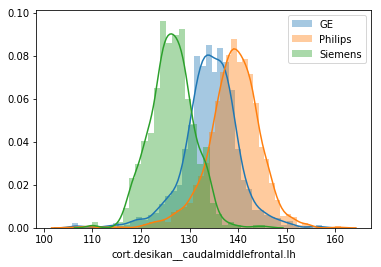

In [254]:
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

metric='t2w.white02'
roi='cort.desikan__caudalmiddlefrontal.lh'
idf = longtbl.query('metric == @metric').loc[:, ['mri_info_manufacturer', roi,'interview_age']]
g_dat=idf.query("mri_info_manufacturer == 'GE MEDICAL SYSTEMS'").loc[idf[roi].notnull(), roi]
s_dat=idf.query("mri_info_manufacturer == 'SIEMENS'").loc[idf[roi].notnull(), roi]
p_dat=idf.query("mri_info_manufacturer == 'Philips Medical Systems'").loc[idf[roi].notnull(), roi]

sns.distplot(g_dat, label='GE')
sns.distplot(s_dat, label='Philips')
sns.distplot(p_dat, label='Siemens')

plt.legend()

4521    0.128068
4523    0.128689
4524    0.116549
4525    0.106986
4531    0.112972
4535    0.137931
4539    0.115829
4545    0.126547
4546    0.143402
4550    0.127053
4551    0.119234
4552    0.125940
4557    0.108113
4571    0.121851
4572    0.110895
4574    0.143552
4575    0.122848
4583    0.100564
4584    0.120844
4585    0.104819
4589    0.118276
4592    0.118010
4593    0.124049
4598    0.128446
4599    0.120860
4609    0.110862
4611    0.111573
4618    0.111370
4619    0.124244
4622    0.132377
4635    0.128369
4643    0.095090
4645    0.105232
4647    0.140641
4655    0.110547
4659    0.112807
4661    0.135013
4664    0.122119
4671    0.140386
4677    0.109322
4678    0.132604
4680    0.137659
4683    0.117460
4685    0.129092
4686    0.130142
4687    0.118641
4689    0.124265
4690    0.141835
4694    0.145779
4696    0.134996
4699    0.117729
4700    0.128849
4705    0.134581
4718    0.174637
4720    0.116548
4721    0.108733
4727    0.140884
4738    0.104085
4742    0.1321

# dmri

In [73]:
longtbl = pd.read_pickle(data_dir/'long_table.pkz')
longtbl['unique_scanner'] = longtbl.site_id_l + '__' + longtbl.mri_info_deviceserialnumber + '__' + longtbl.mri_info_softwareversion
longtbl['age_3mos'] = (longtbl['interview_age'] // 3) * 3
modality = 'dmri'

In [75]:
full_subjs = get_full_subjects(longtbl, modality, metric_range={'rsi.n0.gwc':4})

metric_cols={}
for mm in longtbl.query('modality == @modality').metric.unique():
    metric_df = longtbl.loc[((longtbl.modality == modality) & (longtbl.metric == mm))].copy()
    unused_cols = metric_df.columns[(metric_df.notnull().sum() == 0)].values
    metric_df.drop(unused_cols, axis=1, inplace=True)

    metric_cols, meta_cols = get_cols(metric_df)
    
    metric_full = metric_df.loc[metric_df.subjectkey.isin(full_subjs), :]
    
    metric_bs = big_sites(100, metric_full, metric_cols).sort_values('subjectkey').reset_index(drop=True)
    
    metric_file = swarm_dir/f'{modality}_{mm}.pkz'
    if True:#not metric_file.exists():
        metric_bs.to_pickle(metric_file)

    # Load permutations or generate them
    modality_perm_file = swarm_dir/f'perms_{modality}.pkz'
    if not modality_perm_file.exists():
        print("No permutation file found. Generating a new one.")
        # within bucket shuffle
        bin_levels = ['gender', 'ehi_ss_score', 'age_3mos']
        modality_perms = gen_binned_perms(metric_bs, bin_levels, n_perms=2000)
        with open(modality_perm_file, 'wb') as h:
            pickle.dump(modality_perms, h)
    else:
        with open(modality_perm_file.as_posix(), 'rb') as h:
            modality_perms = pickle.load(h)


Number of sites with more than 100 scans: 16
Number of scans collected at sites with more than 100 scans: 3184
Number of sites with more than 100 scans: 16
Number of scans collected at sites with more than 100 scans: 3184
Number of sites with more than 100 scans: 16
Number of scans collected at sites with more than 100 scans: 3184
Number of sites with more than 100 scans: 16
Number of scans collected at sites with more than 100 scans: 3184
Number of sites with more than 100 scans: 16
Number of scans collected at sites with more than 100 scans: 3184
Number of sites with more than 100 scans: 16
Number of scans collected at sites with more than 100 scans: 3184
Number of sites with more than 100 scans: 16
Number of scans collected at sites with more than 100 scans: 3184
Number of sites with more than 100 scans: 16
Number of scans collected at sites with more than 100 scans: 3184
Number of sites with more than 100 scans: 16
Number of scans collected at sites with more than 100 scans: 3184
N

In [333]:
users=['nielsond']
#user_cmds = {u:[] for u in users}
users = cycle(users)
pstep = 100
pranges = [(0,101)]
i = 0
loop_n = 4
modality = 'dmri'
for pr in pranges:
    user = next(users)
    cmds = make_cmd_list(user, pr, modality, longtbl.query('modality == @modality').metric.unique(), bundle=1)
    #cmds = make_cmd_list(user, pr, modality, ['rsi.n0.gwc'], bundle=1)
    jobs_per_swarm = 1000
    swarm_files = []
    for ii in range(0, len(cmds), jobs_per_swarm):
        swarm_file = Path('/data/nielsond/abcd/nielson_abcd_2018/swarm_dir/swarm_test_%s_%d_%d_%s_%d_11'%(modality, pr[0],ii,user, loop_n))
        swarm_files.append(swarm_file.as_posix())
        swarm_file.write_text('\n'.join(cmds[ii:ii+jobs_per_swarm]))
        swarm_cmd = f'swarm -f {swarm_file} -g 12 -t auto --logdir ${{USER}}_swarm_log --time 2:30:00 --partition=quick,norm --gres=lscratch:30 --module singularity --exclusive --sbatch "--constraint=core16"'
        user_cmds[user].append(swarm_cmd)
        print(len(cmds[ii:ii+jobs_per_swarm]))

582569

1000


582991

1000


582991

1000


583011

1000


141141

242


In [265]:
for user,items in user_cmds.items():
    if user == getpass.getuser():
        for cmd in items:
            print(cmd)
            ! {cmd}

swarm -f /data/nielsond/abcd/nielson_abcd_2018/swarm_dir/swarm_test_dmri_0_0_nielsond_4_11 -g 12 -t auto --logdir ${USER}_swarm_log --time 2:30:00 --partition=quick,norm --gres=lscratch:30 --module singularity --exclusive --sbatch "--constraint=core16"
15869985
swarm -f /data/nielsond/abcd/nielson_abcd_2018/swarm_dir/swarm_test_dmri_0_1000_nielsond_4_11 -g 12 -t auto --logdir ${USER}_swarm_log --time 2:30:00 --partition=quick,norm --gres=lscratch:30 --module singularity --exclusive --sbatch "--constraint=core16"
15869988


In [341]:
len(user_cmds['nielsond'])

20

In [342]:
for user,items in user_cmds.items():
    if user == getpass.getuser():
        for cmd in items[1:]:
            notsubmitted = True
            while notsubmitted:
                print(cmd)
                !{cmd}
                if _exit_code == 0:
                    notsubmitted=False
                else:
                    print("wait an hour and then try again")
                    time.sleep(3600)

swarm -f /data/nielsond/abcd/nielson_abcd_2018/swarm_dir/swarm_test_tfmri_0_1000_nielsond_4_11 -g 12 -t auto --logdir ${USER}_swarm_log --time 2:30:00 --partition=quick,norm --gres=lscratch:30 --module singularity --exclusive --sbatch "--constraint=core16"
15897435
swarm -f /data/nielsond/abcd/nielson_abcd_2018/swarm_dir/swarm_test_tfmri_0_2000_nielsond_4_11 -g 12 -t auto --logdir ${USER}_swarm_log --time 2:30:00 --partition=quick,norm --gres=lscratch:30 --module singularity --exclusive --sbatch "--constraint=core16"
15897436
swarm -f /data/nielsond/abcd/nielson_abcd_2018/swarm_dir/swarm_test_tfmri_0_3000_nielsond_4_11 -g 12 -t auto --logdir ${USER}_swarm_log --time 2:30:00 --partition=quick,norm --gres=lscratch:30 --module singularity --exclusive --sbatch "--constraint=core16"
15897437
swarm -f /data/nielsond/abcd/nielson_abcd_2018/swarm_dir/swarm_test_tfmri_0_4000_nielsond_4_11 -g 12 -t auto --logdir ${USER}_swarm_log --time 2:30:00 --partition=quick,norm --gres=lscratch:30 --module 

wait an hour and then try again
swarm -f /data/nielsond/abcd/nielson_abcd_2018/swarm_dir/swarm_test_dmri_0_1000_nielsond_4_11 -g 12 -t auto --logdir ${USER}_swarm_log --time 2:30:00 --partition=quick,norm --gres=lscratch:30 --module singularity --exclusive --sbatch "--constraint=core16"
15922496
swarm -f /data/nielsond/abcd/nielson_abcd_2018/swarm_dir/swarm_test_dmri_0_2000_nielsond_4_11 -g 12 -t auto --logdir ${USER}_swarm_log --time 2:30:00 --partition=quick,norm --gres=lscratch:30 --module singularity --exclusive --sbatch "--constraint=core16"
sbatch.exe: error: Batch job submission failed: Job violates accounting/QOS policy (job submit limit, user's size and/or time limits)
ERROR: Something went wrong with sbatch!  I don't know the jobid!
wait an hour and then try again
swarm -f /data/nielsond/abcd/nielson_abcd_2018/swarm_dir/swarm_test_dmri_0_2000_nielsond_4_11 -g 12 -t auto --logdir ${USER}_swarm_log --time 2:30:00 --partition=quick,norm --gres=lscratch:30 --module singularity --

KeyboardInterrupt: 

# Prep for multi user run


In [66]:
users=['nielsond', 'adamt']
user_cmds = {u:[] for u in users}
users = cycle(users)
pstep = 50
pranges = [(0, 50),
           (50,100),
           (100,150),
           (150,200)]
i = 0
loop_n = 4
swarm_files = []
jobs_per_swarm = 1000
#modality = 'smri'
modalities=['smri', 'dmri', 'tfmri']

crt_combinations = longtbl.query('modality == "tfmri" & metric == "beta" & run != "all"').groupby(['task','contrast','run']).size().reset_index().drop(0,axis=1).to_records(index=False)
for pr in pranges:
    for modality in modalities:
        user = next(users)
        if modality != 'tfmri':
            cmds = make_cmd_list(user, pr, modality, longtbl.query('modality == @modality').metric.unique(), bundle=1,
                                out_base='/data/MLDSST/abcd/',
                                swarm_dir='/data/MLDSST/abcd/abcd_swarm_dir')
        else:
            cmds=[]
            for task, contrast, run in crt_combinations:
                cmds.extend(make_cmd_list(user, pr, modality, 'beta', bundle=2, run=run, task=task, contrast=contrast, out_base='/data/MLDSST/abcd/',
                                swarm_dir='/data/MLDSST/abcd/abcd_swarm_dir'))
            
        for ii in range(0, len(cmds), jobs_per_swarm):
            swarm_file = Path('/data/MLDSST/abcd/abcd_swarm_dir/swarm_test_%s_%d_%d_%s_%d_11'%(modality, pr[0],ii,user, loop_n))
            swarm_files.append(swarm_file.as_posix())
            swarm_file.write_text('\n'.join(cmds[ii:ii+jobs_per_swarm]))
            swarm_cmd = f'swarm -f {swarm_file} -g 12 -t auto --logdir ${{USER}}_swarm_log --time 2:30:00 --partition=quick,norm --gres=lscratch:30 --module singularity --exclusive --sbatch "--constraint=core16"'
            user_cmds[user].append(swarm_cmd)
            print(len(cmds[ii:ii+jobs_per_swarm]))


17257

35


502569

1000


502991

1000


50317

100


1117799

1000


1117799

1000


1065799

1000


1083399

1000


1121799

1000


225319

200


299799

600


502989

1000


502991

1000


50317

100


1118199

1000


1118199

1000


1066199

1000


1083799

1000


1122199

1000


225399

200


300399

600


503989

1000


503991

1000


50417

100


1120199

1000


1120199

1000


1068199

1000


1085799

1000


1124199

1000


225799

200


300399

600


503989

1000


503991

1000


50417

100


1120199

1000


1120199

1000


1068199

1000


1085799

1000


1124199

1000


225799

200


In [59]:
user_cmds['adamt']

['swarm -f /data/MLDSST/abcd/abcd_swarm_dir/swarm_test_dmri_0_0_adamt_4_11 -g 12 -t auto --logdir ${USER}_swarm_log --time 2:30:00 --partition=quick,norm --gres=lscratch:30 --module singularity --exclusive --sbatch "--constraint=core16"',
 'swarm -f /data/MLDSST/abcd/abcd_swarm_dir/swarm_test_dmri_0_1000_adamt_4_11 -g 12 -t auto --logdir ${USER}_swarm_log --time 2:30:00 --partition=quick,norm --gres=lscratch:30 --module singularity --exclusive --sbatch "--constraint=core16"',
 'swarm -f /data/MLDSST/abcd/abcd_swarm_dir/swarm_test_dmri_0_2000_adamt_4_11 -g 12 -t auto --logdir ${USER}_swarm_log --time 2:30:00 --partition=quick,norm --gres=lscratch:30 --module singularity --exclusive --sbatch "--constraint=core16"',
 'swarm -f /data/MLDSST/abcd/abcd_swarm_dir/swarm_test_smri_50_0_adamt_4_11 -g 12 -t auto --logdir ${USER}_swarm_log --time 2:30:00 --partition=quick,norm --gres=lscratch:30 --module singularity --exclusive --sbatch "--constraint=core16"',
 'swarm -f /data/MLDSST/abcd/abcd_swa

In [69]:
!{user_cmds['nielsond'][0]}

15985043


In [70]:
!{user_cmds['nielsond'][1]}

15985228


In [67]:
user_cmds['nielsond']

['swarm -f /data/MLDSST/abcd/abcd_swarm_dir/swarm_test_smri_0_0_nielsond_4_11 -g 12 -t auto --logdir ${USER}_swarm_log --time 2:30:00 --partition=quick,norm --gres=lscratch:30 --module singularity --exclusive --sbatch "--constraint=core16"',
 'swarm -f /data/MLDSST/abcd/abcd_swarm_dir/swarm_test_tfmri_0_0_nielsond_4_11 -g 12 -t auto --logdir ${USER}_swarm_log --time 2:30:00 --partition=quick,norm --gres=lscratch:30 --module singularity --exclusive --sbatch "--constraint=core16"',
 'swarm -f /data/MLDSST/abcd/abcd_swarm_dir/swarm_test_tfmri_0_1000_nielsond_4_11 -g 12 -t auto --logdir ${USER}_swarm_log --time 2:30:00 --partition=quick,norm --gres=lscratch:30 --module singularity --exclusive --sbatch "--constraint=core16"',
 'swarm -f /data/MLDSST/abcd/abcd_swarm_dir/swarm_test_tfmri_0_2000_nielsond_4_11 -g 12 -t auto --logdir ${USER}_swarm_log --time 2:30:00 --partition=quick,norm --gres=lscratch:30 --module singularity --exclusive --sbatch "--constraint=core16"',
 'swarm -f /data/MLDSST

In [ ]:
import time
for user,items in user_cmds.items():
    if user == getpass.getuser():
        for cmd in items[2:]:
            notsubmitted = True
            while notsubmitted:
                print(cmd)
                !{cmd}
                if _exit_code == 0:
                    notsubmitted=False
                else:
                    print("wait an hour and then try again")
                    time.sleep(3600)

swarm -f /data/MLDSST/abcd/abcd_swarm_dir/swarm_test_tfmri_0_1000_nielsond_4_11 -g 12 -t auto --logdir ${USER}_swarm_log --time 2:30:00 --partition=quick,norm --gres=lscratch:30 --module singularity --exclusive --sbatch "--constraint=core16"
15986830
swarm -f /data/MLDSST/abcd/abcd_swarm_dir/swarm_test_tfmri_0_2000_nielsond_4_11 -g 12 -t auto --logdir ${USER}_swarm_log --time 2:30:00 --partition=quick,norm --gres=lscratch:30 --module singularity --exclusive --sbatch "--constraint=core16"
15986832
swarm -f /data/MLDSST/abcd/abcd_swarm_dir/swarm_test_tfmri_0_3000_nielsond_4_11 -g 12 -t auto --logdir ${USER}_swarm_log --time 2:30:00 --partition=quick,norm --gres=lscratch:30 --module singularity --exclusive --sbatch "--constraint=core16"
15986835
swarm -f /data/MLDSST/abcd/abcd_swarm_dir/swarm_test_tfmri_0_4000_nielsond_4_11 -g 12 -t auto --logdir ${USER}_swarm_log --time 2:30:00 --partition=quick,norm --gres=lscratch:30 --module singularity --exclusive --sbatch "--constraint=core16"
sbatc

sbatch.exe: error: Batch job submission failed: Job violates accounting/QOS policy (job submit limit, user's size and/or time limits)
ERROR: Something went wrong with sbatch!  I don't know the jobid!
wait an hour and then try again
swarm -f /data/MLDSST/abcd/abcd_swarm_dir/swarm_test_tfmri_100_4000_nielsond_4_11 -g 12 -t auto --logdir ${USER}_swarm_log --time 2:30:00 --partition=quick,norm --gres=lscratch:30 --module singularity --exclusive --sbatch "--constraint=core16"
sbatch.exe: error: Batch job submission failed: Job violates accounting/QOS policy (job submit limit, user's size and/or time limits)
ERROR: Something went wrong with sbatch!  I don't know the jobid!
wait an hour and then try again
swarm -f /data/MLDSST/abcd/abcd_swarm_dir/swarm_test_tfmri_100_4000_nielsond_4_11 -g 12 -t auto --logdir ${USER}_swarm_log --time 2:30:00 --partition=quick,norm --gres=lscratch:30 --module singularity --exclusive --sbatch "--constraint=core16"
16040369
swarm -f /data/MLDSST/abcd/abcd_swarm_d

In [ ]:
0: 15980554, 1: 15985228

In [ ]:
user_cmds = {}
user_cmds['adamt'] = ['swarm -f /data/MLDSST/abcd/abcd_swarm_dir/swarm_test_dmri_0_0_adamt_4_11 -g 12 -t auto --logdir ${USER}_swarm_log --time 2:30:00 --partition=quick,norm --gres=lscratch:30 --module singularity --exclusive --sbatch "--constraint=core16"',
                     'swarm -f /data/MLDSST/abcd/abcd_swarm_dir/swarm_test_dmri_0_1000_adamt_4_11 -g 12 -t auto --logdir ${USER}_swarm_log --time 2:30:00 --partition=quick,norm --gres=lscratch:30 --module singularity --exclusive --sbatch "--constraint=core16"',
                     'swarm -f /data/MLDSST/abcd/abcd_swarm_dir/swarm_test_dmri_0_2000_adamt_4_11 -g 12 -t auto --logdir ${USER}_swarm_log --time 2:30:00 --partition=quick,norm --gres=lscratch:30 --module singularity --exclusive --sbatch "--constraint=core16"',
                     'swarm -f /data/MLDSST/abcd/abcd_swarm_dir/swarm_test_smri_50_0_adamt_4_11 -g 12 -t auto --logdir ${USER}_swarm_log --time 2:30:00 --partition=quick,norm --gres=lscratch:30 --module singularity --exclusive --sbatch "--constraint=core16"',
                     'swarm -f /data/MLDSST/abcd/abcd_swarm_dir/swarm_test_tfmri_50_0_adamt_4_11 -g 12 -t auto --logdir ${USER}_swarm_log --time 2:30:00 --partition=quick,norm --gres=lscratch:30 --module singularity --exclusive --sbatch "--constraint=core16"',
                     'swarm -f /data/MLDSST/abcd/abcd_swarm_dir/swarm_test_tfmri_50_1000_adamt_4_11 -g 12 -t auto --logdir ${USER}_swarm_log --time 2:30:00 --partition=quick,norm --gres=lscratch:30 --module singularity --exclusive --sbatch "--constraint=core16"',
                     'swarm -f /data/MLDSST/abcd/abcd_swarm_dir/swarm_test_tfmri_50_2000_adamt_4_11 -g 12 -t auto --logdir ${USER}_swarm_log --time 2:30:00 --partition=quick,norm --gres=lscratch:30 --module singularity --exclusive --sbatch "--constraint=core16"',
                     'swarm -f /data/MLDSST/abcd/abcd_swarm_dir/swarm_test_tfmri_50_3000_adamt_4_11 -g 12 -t auto --logdir ${USER}_swarm_log --time 2:30:00 --partition=quick,norm --gres=lscratch:30 --module singularity --exclusive --sbatch "--constraint=core16"',
                     'swarm -f /data/MLDSST/abcd/abcd_swarm_dir/swarm_test_tfmri_50_4000_adamt_4_11 -g 12 -t auto --logdir ${USER}_swarm_log --time 2:30:00 --partition=quick,norm --gres=lscratch:30 --module singularity --exclusive --sbatch "--constraint=core16"',
                     'swarm -f /data/MLDSST/abcd/abcd_swarm_dir/swarm_test_tfmri_50_5000_adamt_4_11 -g 12 -t auto --logdir ${USER}_swarm_log --time 2:30:00 --partition=quick,norm --gres=lscratch:30 --module singularity --exclusive --sbatch "--constraint=core16"',
                     'swarm -f /data/MLDSST/abcd/abcd_swarm_dir/swarm_test_dmri_100_0_adamt_4_11 -g 12 -t auto --logdir ${USER}_swarm_log --time 2:30:00 --partition=quick,norm --gres=lscratch:30 --module singularity --exclusive --sbatch "--constraint=core16"',
                     'swarm -f /data/MLDSST/abcd/abcd_swarm_dir/swarm_test_dmri_100_1000_adamt_4_11 -g 12 -t auto --logdir ${USER}_swarm_log --time 2:30:00 --partition=quick,norm --gres=lscratch:30 --module singularity --exclusive --sbatch "--constraint=core16"',
                     'swarm -f /data/MLDSST/abcd/abcd_swarm_dir/swarm_test_dmri_100_2000_adamt_4_11 -g 12 -t auto --logdir ${USER}_swarm_log --time 2:30:00 --partition=quick,norm --gres=lscratch:30 --module singularity --exclusive --sbatch "--constraint=core16"',
                     'swarm -f /data/MLDSST/abcd/abcd_swarm_dir/swarm_test_smri_150_0_adamt_4_11 -g 12 -t auto --logdir ${USER}_swarm_log --time 2:30:00 --partition=quick,norm --gres=lscratch:30 --module singularity --exclusive --sbatch "--constraint=core16"',
                     'swarm -f /data/MLDSST/abcd/abcd_swarm_dir/swarm_test_tfmri_150_0_adamt_4_11 -g 12 -t auto --logdir ${USER}_swarm_log --time 2:30:00 --partition=quick,norm --gres=lscratch:30 --module singularity --exclusive --sbatch "--constraint=core16"',
                     'swarm -f /data/MLDSST/abcd/abcd_swarm_dir/swarm_test_tfmri_150_1000_adamt_4_11 -g 12 -t auto --logdir ${USER}_swarm_log --time 2:30:00 --partition=quick,norm --gres=lscratch:30 --module singularity --exclusive --sbatch "--constraint=core16"',
                     'swarm -f /data/MLDSST/abcd/abcd_swarm_dir/swarm_test_tfmri_150_2000_adamt_4_11 -g 12 -t auto --logdir ${USER}_swarm_log --time 2:30:00 --partition=quick,norm --gres=lscratch:30 --module singularity --exclusive --sbatch "--constraint=core16"',
                     'swarm -f /data/MLDSST/abcd/abcd_swarm_dir/swarm_test_tfmri_150_3000_adamt_4_11 -g 12 -t auto --logdir ${USER}_swarm_log --time 2:30:00 --partition=quick,norm --gres=lscratch:30 --module singularity --exclusive --sbatch "--constraint=core16"',
                     'swarm -f /data/MLDSST/abcd/abcd_swarm_dir/swarm_test_tfmri_150_4000_adamt_4_11 -g 12 -t auto --logdir ${USER}_swarm_log --time 2:30:00 --partition=quick,norm --gres=lscratch:30 --module singularity --exclusive --sbatch "--constraint=core16"',
                     'swarm -f /data/MLDSST/abcd/abcd_swarm_dir/swarm_test_tfmri_150_5000_adamt_4_11 -g 12 -t auto --logdir ${USER}_swarm_log --time 2:30:00 --partition=quick,norm --gres=lscratch:30 --module singularity --exclusive --sbatch "--constraint=core16"']

import time
import getpass
for user,items in user_cmds.items():
    if user == getpass.getuser():
        for cmd in items[1:]:
            notsubmitted = True
            while notsubmitted:
                print(cmd)
                !{cmd}
                if _exit_code == 0:
                    notsubmitted=False
                else:
                    print("wait an hour and then try again")
                    time.sleep(3600)